In [51]:
%pip install pandas
%pip install huggingface_hub
%pip install datasets
%pip install openai
%pip install python-dotenv
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [100]:
from datasets import load_dataset

ds = load_dataset("biglab/webui-350k-elements")
# ds = load_dataset("agentsea/wave-ui-25k")

In [53]:
from openai import OpenAI
import io
import base64
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get the value of the API key from the environment variable
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [54]:
def image_to_base64(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def process_sample(sample):
    # Convert PIL Image to base64
    image_base64 = image_to_base64(sample["image"])

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Describe this UI element.",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_base64}",
                        },
                    },
                ],
            }
        ],
        max_tokens=300,
    )

    return {
        "custom_id": sample["key_name"],
        "labels": sample["labels"],
        "description": response.choices[0].message.content,
    }

In [57]:
import csv
from PIL import ImageDraw
import os
from tqdm import tqdm

def apply_bboxes_to_image(image, bboxes):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        x1, y1, x2, y2 = tuple(bbox)
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    return image


def get_description_from_claude(sample):
    image = sample["image"]
    image = apply_bboxes_to_image(image, sample["bbox"])
    # Convert image to base64
    image_base64 = image_to_base64(sample["image"])

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Describe this UI element.",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_base64}",
                        },
                    },
                ],
            }
        ],
        max_tokens=300,
    )

    return response.choices[0].message.content


def generate_descriptions_and_save_csv(split="train", num_samples=None):
    csv_filename = f"{split}_descriptions.csv"
    image_dir = "data/wave-ui-25k"
    os.makedirs(image_dir, exist_ok=True)

    # logs
    total_cost = 0
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["index", "image_path", "description"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for idx, row in tqdm(enumerate(ds[split]), total=num_samples or len(ds[split])):
            if num_samples and idx >= num_samples:
                break

            image = row["image"]
            bbox = row["bbox"]

            img_with_bbox = apply_bboxes_to_image(image, bbox)
            image_filename = f"{split}_{idx}.png"
            image_path = os.path.join(image_dir, image_filename)

            # Convert RGBA to RGB before saving as JPEG
            rgb_image = img_with_bbox.convert("RGB")
            rgb_image.save(image_path, "JPEG")

            description, cost = get_description_from_claude(img_with_bbox)
            print(f"cost: ${cost}")
            total_cost += cost

            writer.writerow(
                {"index": idx, "image_path": image_path, "description": description}
            )

    print(f"Descriptions saved to {csv_filename}")
    print(f"Images saved in {image_dir}")


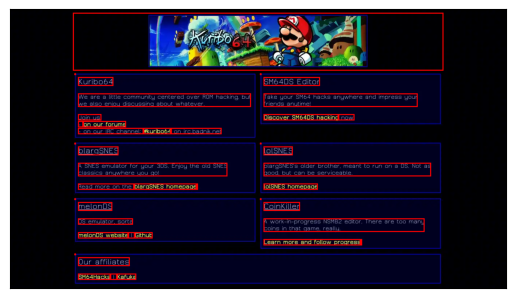

In [127]:
import random
import matplotlib.pyplot as plt

# Take a random sample
random_index = random.randint(0, len(ds["train"]) - 1)
sample = ds["train"][random_index]

# Get the image and its metadata
image = sample["image"]
bbox = sample["borderBoxes"]

# Apply bounding box to the image
image_with_bbox = apply_bboxes_to_image(image.copy(), bbox)

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image with bounding box
ax.imshow(image_with_bbox)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [91]:
test_samples = ds["train"].select(range(1))
results = []

for sample in test_samples:
    result = process_sample(sample)
    results.append(result)
    print(f"Processed sample {result['custom_id']}")

# Display the results
for result in results:
    print(f"Sample {result['custom_id']}:")
    print(f"Image URL: {result['labels']}")
    print(f"Description: {result['description']}")
    print("---")

KeyboardInterrupt: 